In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import PdM_functions as pdm # custom functions created for this project that are used in several notebooks

In [224]:
# Load the data
telemetry = pd.read_csv('data/PdM Azure/PdM_telemetry.csv', sep = ",")
errors = pd.read_csv('data/PdM Azure/PdM_errors.csv', sep = ",")
failures = pd.read_csv('data/PdM Azure/PdM_failures.csv', sep = ",")
machines = pd.read_csv('data/PdM Azure/PdM_machines.csv', sep = ",")
maint = pd.read_csv('data/PdM Azure/PdM_maint.csv', sep = ",")

In [225]:
# Map failures
print('Failure types: ', failures['failure'].unique())
failure_map = {
    'Normal':0, 
    'comp1':1, 
    'comp2':2, 
    'comp3':3,
    'comp4':4
}

Failure types:  ['comp4' 'comp1' 'comp2' 'comp3']


In [226]:
# Map errors
print('Error types: ', errors['errorID'].unique())
error_map = {
    'Normal':0, 
    'error1':1, 
    'error2':2, 
    'error3':3,
    'error4':4,
    'error4':5
}

Error types:  ['error1' 'error3' 'error5' 'error4' 'error2']


In [227]:
# Map model types
print('Model types: ', machines['model'].unique())
model_map = {
    'model1':1, 
    'model2':2, 
    'model3':3, 
    'model4':4
}

Model types:  ['model3' 'model4' 'model2' 'model1']


In [228]:
# Map component reference for maintenance
print('Comp types: ', maint['comp'].unique())
comp_map = {
    'No':0, 
    'comp1':1, 
    'comp2':2, 
    'comp3':3, 
    'comp4':4
}

Comp types:  ['comp2' 'comp4' 'comp3' 'comp1']


In [229]:
def create_machine_df(tel, fail, err, maint, det, m_id):
    """
    Create a function for combing data for a selected machine:        
        Args:
            tel (DataFrame): Sensor data for all machines
            fail (DataFrame): Failure times & failed components
            err (DataFrame): Error code history
            det (DataFrame): Machine details, e.g., model ref. & age
            m_id (int): What machine number to focus on
        
        Returns:
            machine_df (DataFrame): DataFrame of comabined data for a selected machine
    """    
    machine_df = tel.loc[tel['machineID'] == m_id,:]
    failure1 = fail.loc[fail['machineID'] == m_id,:].drop('machineID', axis = 1)
    error1 = err.loc[err['machineID'] == m_id,:].drop('machineID', axis = 1)
    maint1 = maint.loc[maint['machineID'] == m_id,:].drop('machineID', axis = 1)
    detail1 =  det.loc[det['machineID'] == m_id,:]
    machine_df = pd.merge(machine_df, failure1, on = 'datetime', how = 'left')
    machine_df['failure'].replace({np.nan: 'Normal'}, inplace=True)
    machine_df = pd.merge(machine_df, error1, on = 'datetime', how = 'left')
    machine_df['errorID'].replace({np.nan: 'Normal'}, inplace=True)
    machine_df = pd.merge(machine_df, maint1, on = 'datetime', how = 'left')
    machine_df['comp'].replace({np.nan: 'No'}, inplace=True)
    machine_df = pd.merge(machine_df, detail1, on = 'machineID', how = 'left')    
    machine_df['failure'] = machine_df['failure'].map(failure_map)
    machine_df['errorID'] = machine_df['errorID'].map(error_map)
    machine_df['model'] = machine_df['model'].map(model_map)
    machine_df['comp'] = machine_df['comp'].map(comp_map)
    machine_df.rename(columns = {'comp': 'maintenance'}, inplace = True)
    machine_df.rename(columns = {'datetime': 'timestamp'}, inplace = True)
    machine_df.index = pd.to_datetime(machine_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
    return(machine_df)

In [230]:
df_set = create_machine_df(telemetry, failures, errors, maint, machines, 1)

In [231]:
df_set.describe()

,machineID,volt,rotate,pressure,vibration,failure,errorID,maintenance,model,age
count,8772.0,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000,8768.000000,8772.000000,8772.0,8772.0
mean,1.0,170.844541,446.318599,100.669813,40.590360,0.003990,0.008554,0.009006,3.0,18.0
std,0.0,15.321281,52.238409,10.860018,5.545622,0.119313,0.165579,0.162738,0.0,0.0
min,1.0,119.059047,215.619476,58.733724,22.666865,0.000000,0.000000,0.000000,3.0,18.0
25%,1.0,160.373992,412.254408,93.330259,36.848581,0.000000,0.000000,0.000000,3.0,18.0
50%,1.0,170.625508,447.668563,100.327769,40.418921,0.000000,0.000000,0.000000,3.0,18.0
75%,1.0,180.955518,481.359194,107.378348,44.004820,0.000000,0.000000,0.000000,3.0,18.0
max,1.0,237.938518,636.364569,155.257527,67.633435,4.000000,5.000000,4.000000,3.0,18.0


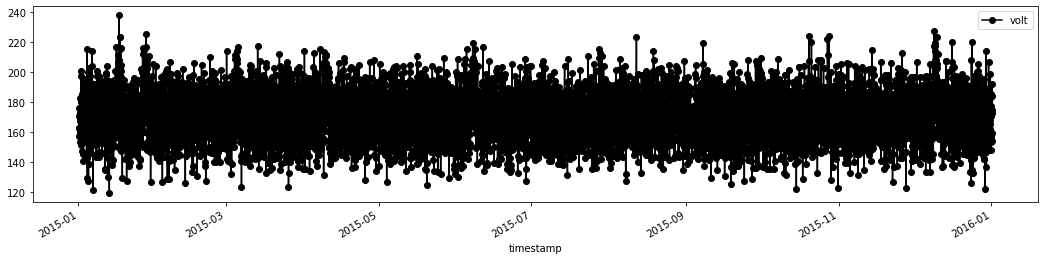

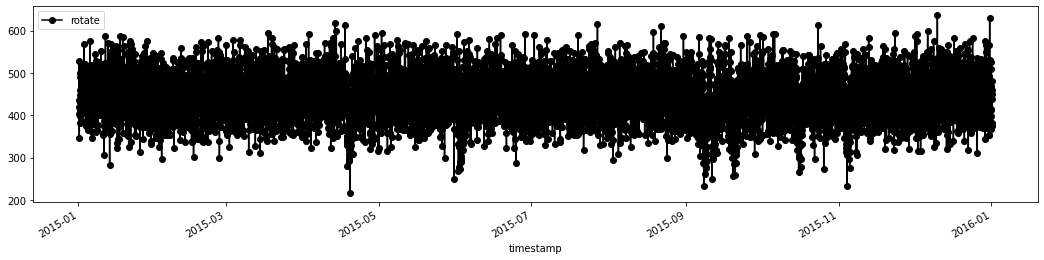

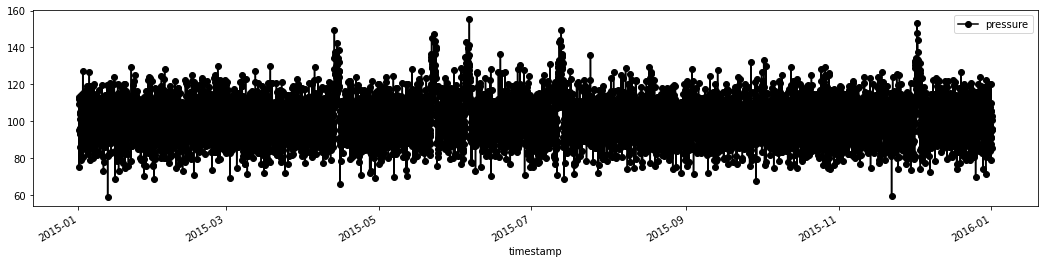

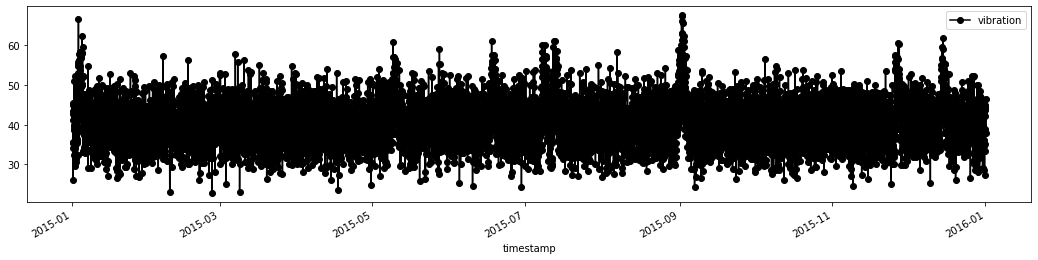

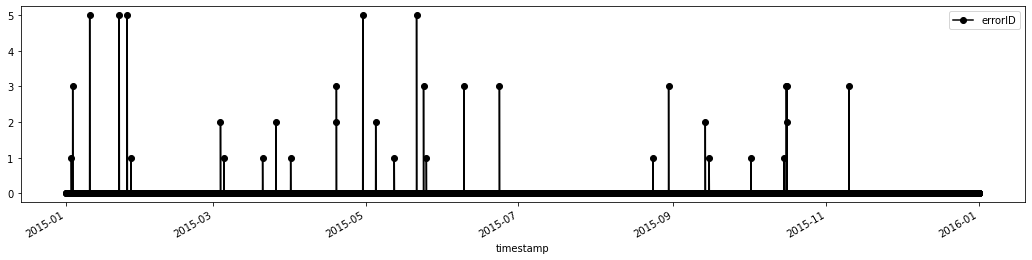

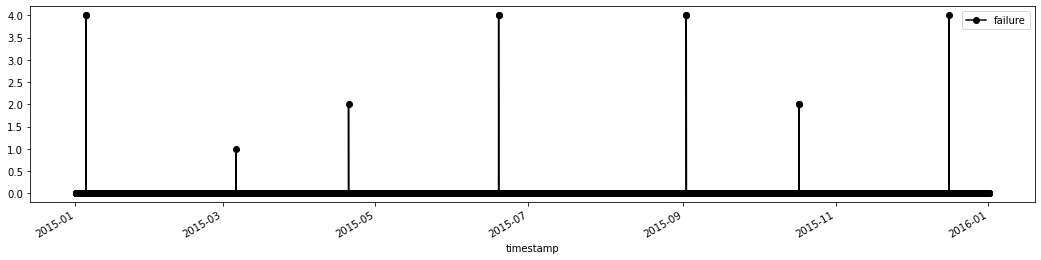

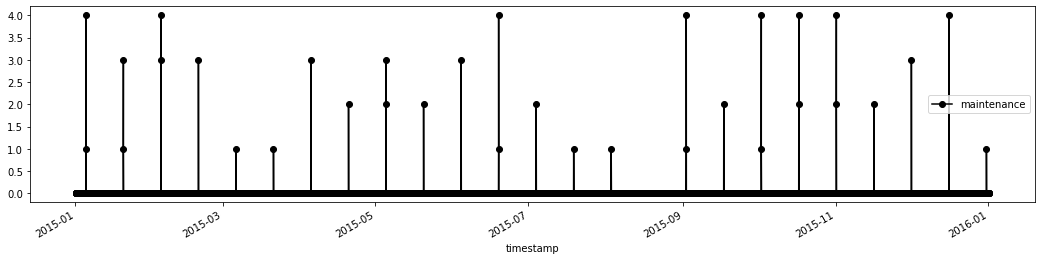

In [232]:
# Check the results of cleaning
plot_chans = ['volt', 'rotate', 'pressure', 'vibration', 'errorID', 'failure', 'maintenance']
for sen in plot_chans:
    df_set[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

### Data Scaling

In [233]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib.pyplot import figure
from itertools import groupby

In [234]:
df_set['failure'].unique()

array([0, 4, 1, 2])

In [235]:
# Scale the data (between 0 and 1)
drops = [
    'machineID',
    'timestamp',
    'errorID', 
    'failure', 
    'maintenance',
    'model',
    'age'
]
df_num = df_set.drop(drops, axis = 1)
scaler = preprocessing.MinMaxScaler()
df_set_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns, index = df_num.index)
df_set_scaled['timestamp'] = df_set['timestamp']
df_set_scaled['failure'] = df_set['failure'].tolist()
df_set_scaled.describe()

,volt,rotate,pressure,vibration,failure
count,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000
mean,0.435613,0.548311,0.434464,0.398596,0.003990
std,0.128881,0.124157,0.112511,0.123328,0.119313
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.347536,0.467349,0.358425,0.315384,0.000000
50%,0.433771,0.551519,0.430920,0.394783,0.000000
75%,0.520666,0.631593,0.503965,0.474529,0.000000
max,1.000000,1.000000,1.000000,1.000000,4.000000


In [236]:
df_set_scaled['failure'].unique()

array([0, 4, 1, 2])

In [237]:
# Remove periods when pump was broken or covering + transition window
trans_win = 1*24

# Create map to reduce categories to two
# We want to remove 'recovering' so combine it with 'broken'
condition_map = {
    0: 'NORMAL', 
    1: 'FAIL', 
    2: 'FAIL',
    #3: 'FAIL',
    4: 'FAIL',
}

In [238]:
# Use besploke function from pdm_functions
df_norm, df_abnorm = pdm.remove_segements(
    segment_vec = df_set_scaled['failure'],
    mapping = condition_map,
    dat = df_set_scaled,
    trans_window = trans_win,
    keep = 'NORMAL'
)

Input segement categories:  [0 4 1 2]
Categories after mapping:  ['NORMAL' 'FAIL']
Run length encoding:  [('NORMAL', 96), ('FAIL', 2), ('NORMAL', 1441), ('FAIL', 1), ('NORMAL', 1080), ('FAIL', 1), ('NORMAL', 1440), ('FAIL', 2), ('NORMAL', 1799), ('FAIL', 2), ('NORMAL', 1081), ('FAIL', 2), ('NORMAL', 1440), ('FAIL', 1), ('NORMAL', 384)]
>
Skipping NORMAL segment(s)...
>
Remove rows:  [72, 121]
Removing 50 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [1515, 1563]
Removing 49 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [2596, 2644]
Removing 49 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [4037, 4086]
Removing 50 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [5838, 5887]
Removing 50 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [6921, 6970]
Removing 50 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [8363, 8411]
Removing 49 rows...
>
Skipping NORMAL segment(s)...


In [242]:
# Check row counts
tot_rows = len(df_norm) + len(df_abnorm)
print('Nrows normal: ' + str(len(df_norm)) + ' (' + str(round(100*len(df_norm)/tot_rows)) + '%)')
print('Nrows abnorm: ' + str(len(df_abnorm)) + ' (' + str(round(100*len(df_abnorm)/tot_rows)) + '%)')

Nrows normal: 8425 (96%)
Nrows abnorm: 347 (4%)


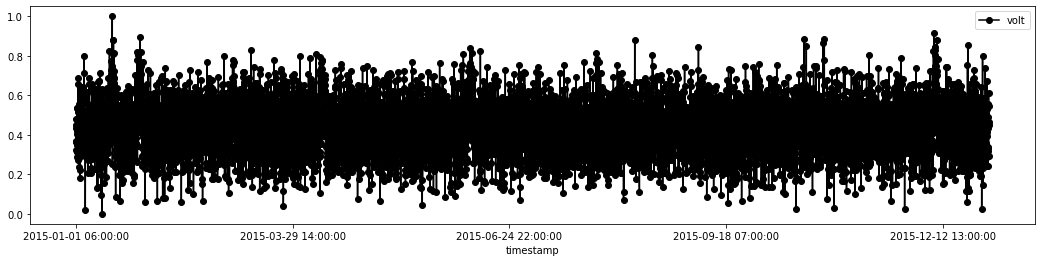

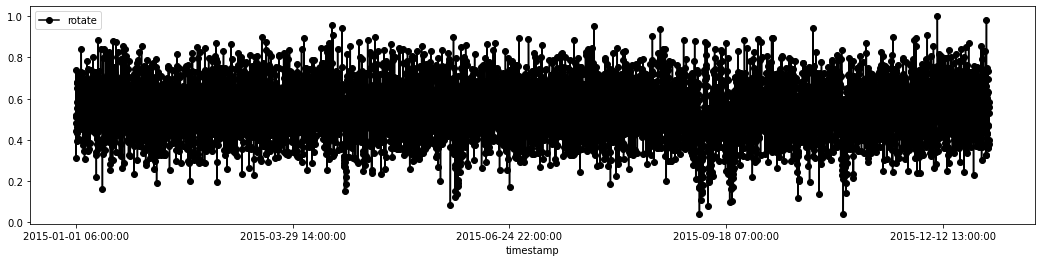

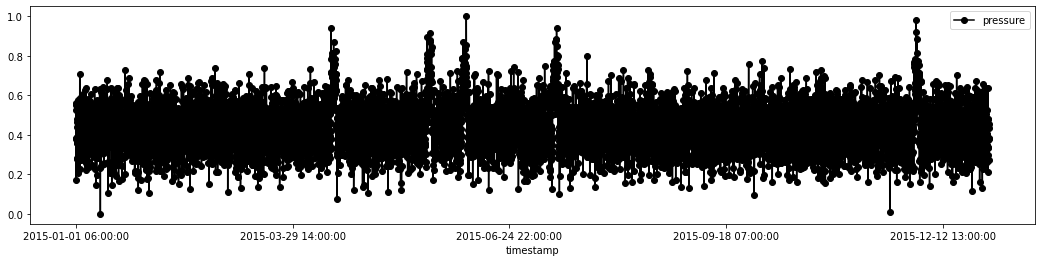

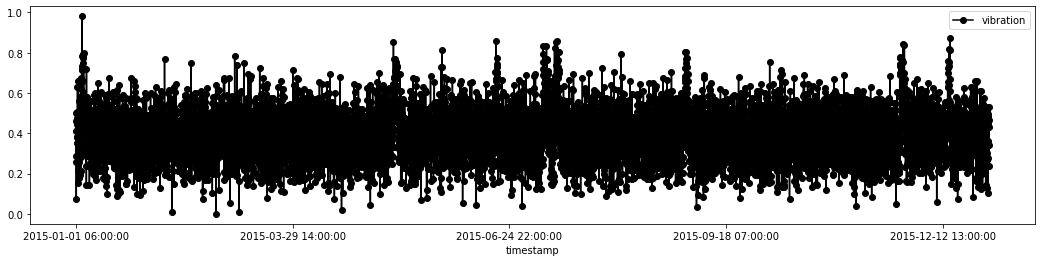

In [245]:
# Check the results of row removal
include_cols = ['volt', 'rotate', 'pressure', 'vibration']
df_plot = df_norm.loc[:,include_cols] 
for sen in df_plot.columns:
    df_plot[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

In [246]:
# Create a timestamp column
df_norm['timestamp'] = pd.to_datetime(df_norm.index, format = '%Y-%m-%d %H:%M:%S')
df_abnorm['timestamp'] = pd.to_datetime(df_abnorm.index, format = '%Y-%m-%d %H:%M:%S')

In [249]:
df_norm

,volt,rotate,pressure,vibration,timestamp,failure
timestamp,,,,,,
2015-01-01 06:00:00,0.480813,0.482203,0.563014,0.498611,2015-01-01 06:00:00,0
2015-01-01 07:00:00,0.368610,0.444754,0.380495,0.461390,2015-01-01 07:00:00,0
2015-01-01 08:00:00,0.436836,0.740901,0.170986,0.256012,2015-01-01 08:00:00,0
2015-01-01 09:00:00,0.365107,0.310235,0.523341,0.410422,2015-01-01 09:00:00,0
2015-01-01 10:00:00,0.324286,0.522305,0.550672,0.073914,2015-01-01 10:00:00,0
...,...,...,...,...,...,...
2016-01-01 02:00:00,0.291604,0.557665,0.274168,0.467709,2016-01-01 02:00:00,0
2016-01-01 03:00:00,0.448850,0.380474,0.381611,0.432428,2016-01-01 03:00:00,0
2016-01-01 04:00:00,0.467104,0.582029,0.380737,0.236325,2016-01-01 04:00:00,0


In [252]:
# Prepare data for PCA
df_train = df_norm
df_train = df_train.drop(['failure', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm
df_test1 = df_test1.drop(['failure', 'timestamp'], axis = 1)  

In [255]:
# Define the PCA model (all compoments)
n_comps = 4 # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test1_PCA = pca.transform(df_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.281 0.262 0.243 0.215]


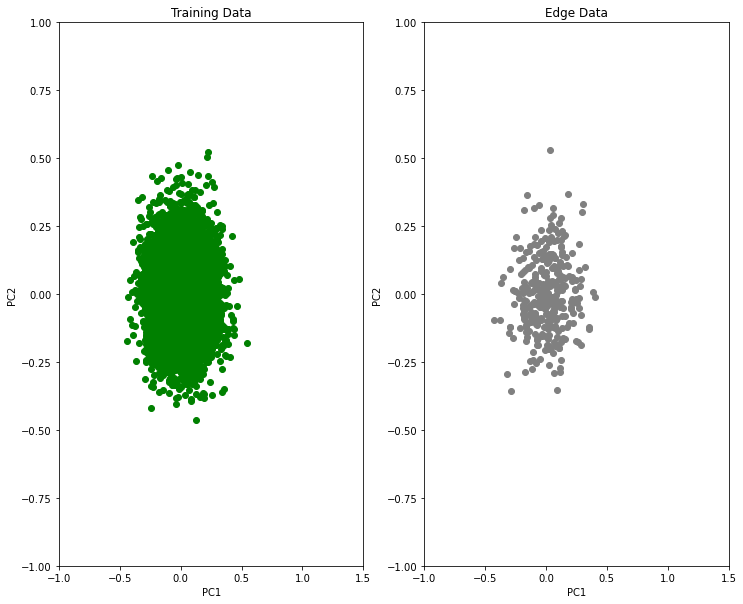

In [256]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(1, 2, figsize = (12, 10))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-1, 1.5)
ax0.set_ylim(-1, 1)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-1, 1.5)
ax1.set_ylim(-1, 1)
ax1.set_title('Edge Data')

plt.show()